# Asset Price Forecast using the ARIMA model 

Predicting Asset Price is a challenging but exciting task considering the reward when the predictions go in line with the actual market data. ARIMA models try to model and predict future prices using past prices. After completing the notebook, you will forecast asset price using the tuned ARIMA model, evaluate model performance, and compare the forecasted and actual values.

In this notebook, you will perform the following steps:

1. [Get Stock data](#data)
2. [Analyse Time Series](#analyze)
3. [Stationarize Time Series](#stationarize)
4. [Search Optimal Parameters](#grid_search)
5. [Forecast using ARIMA model](#forecast)
6. [Evaluate Model Performance](#performance)

## Get Stock Data<a id='data'></a>

In [1]:
# Import pandas datareader
import pandas_datareader as pdr

# Set the start and end date
start_date = '01-Jan-10'
end_date = '01-Feb-20'

# Set the ticker
ticker = 'V'  

# Get stock data 
data = pdr.get_data_yahoo(ticker, start_date, end_date)['Adj Close']

# Print the top 5 rows of the pandas series
data.head()

Date
2009-12-31    20.153343
2010-01-04    20.310040
2010-01-05    20.077301
2010-01-06    19.807703
2010-01-07    19.992043
Name: Adj Close, dtype: float64

## Analyse Time Series<a id='analyze'></a>

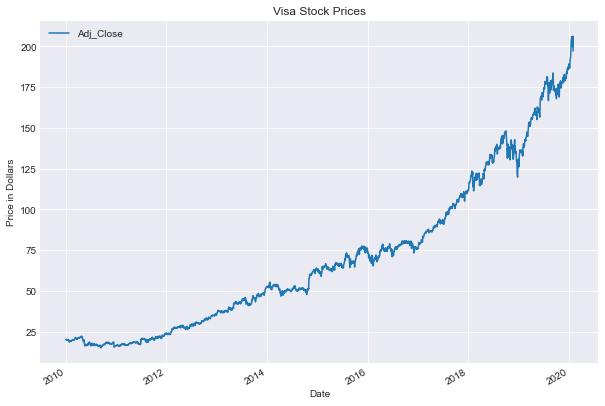

In [2]:
# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)
plt.style.use('seaborn-darkgrid')

# Plot the Adjusted Close Visa stock price
data.plot(figsize=(10, 7))
plt.title('Visa Stock Prices')
plt.ylabel('Price in Dollars')
plt.legend(['Adj_Close'])
plt.show()

Time series is increasing trend hence not stationary. We can confirm this by using the Augmented Dickey-Fuller (ADF) Test, as well as by plotting the Autocorrelation Function (ACF) plot (visual check).

Since modelling involves estimating parameters and if the series is not stationary, there are too many parameters to estimate hence difficult to model. Thus stationarity of series is an important prerequisite for modelling a time series. 

### Augmented Dickey-Fuller test
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05), then you reject the null hypothesis and infer that the time series is indeed stationary. Alternatively, if the p-value is greater than 0.05, we cannot reject the null hypothesis.

In [3]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

# Probability of observing the result in our data by chance
p_value = adfuller(data)[1]

if p_value > 0.05:
    print(
        "The p-value is: {p_value} > 0.05, hence time series is not stationary.".format(p_value=p_value))
else:
    print("Time series is stationary.")

The p-value is: 1.0 > 0.05, hence time series is not stationary.


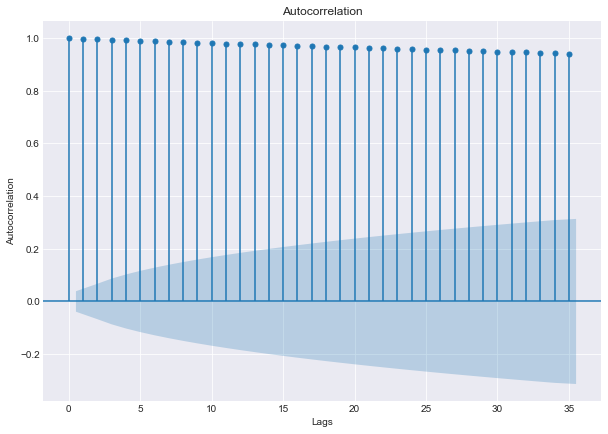

In [4]:
# Import plot_acf
from statsmodels.graphics.tsaplots import plot_acf

# ACF plot of original asset price series
plt.rcParams['figure.figsize'] = (10, 7)
plot_acf(data)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Both the ADF test and ACF plot confirm that our time series is indeed non-stationary.

## Stationarize Time Series<a id='stationarize'></a>

We will plot first order differenced time series to check if resulted series is a stationary time series.

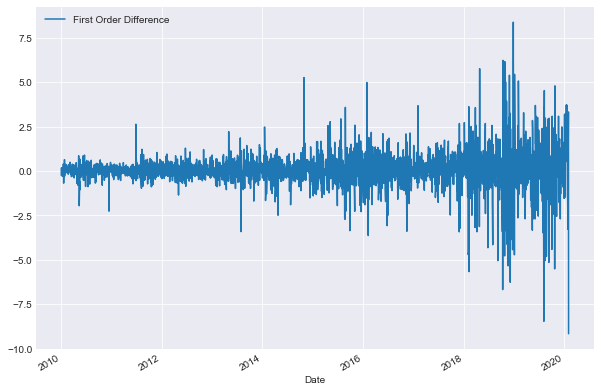

In [5]:
# Plot the First Order Difference of VISA stock price
data.diff().plot(figsize=(10, 7))
plt.xlabel('Date')
plt.legend(['First Order Difference'])
plt.show()

The above plot suggests that we can accept first order differenced time series as the required stationaries time series. One can also check the ACF plot with any next level of differencing. The Autocorrelation values in that case, go into the far negative zone fairly quickly, which indicates the series might have been over-differenced. 

The above time series is not white noise since we can observe data clustering. This also means we can work on a model to make the error residual close to white noise. If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions. When forecast errors are white noise, all of the signal information in the time series has been harnessed by the model to make predictions. All that is left is the random fluctuations that cannot be modelled. 

We'll plot a density plot to confirm the stationarity of the time series.

<Figure size 720x504 with 0 Axes>

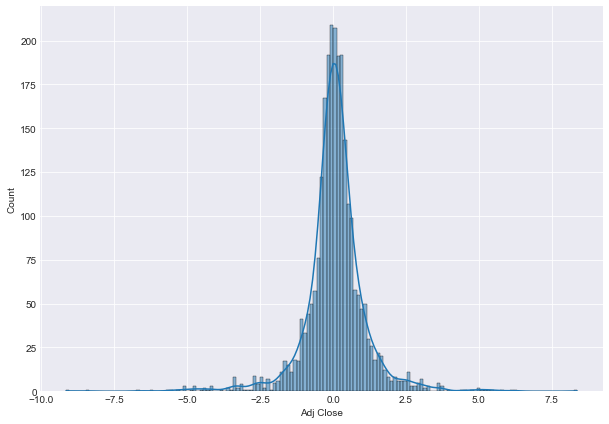

In [6]:
# Density plot
plt.figure(figsize=(10, 7))
sns.displot(data.diff().dropna(), kde=True, height=6, aspect=10/7)
plt.show()

The density plot tells us that we have a near-zero mean and finite uniform variance. Thus satisfy the conditions for a series to be termed as stationary.

## Search Optimal Parameters<a id='grid_search'></a>

We find optimal ARIMA model parameter by observing the Partial Autocorrelation Function(PACF)/ Autocorrelation Function(ACF) plots. 

One can iterate through various (p,q) values to finally select those giving a better information criterion (IC). The lower IC score is the better score.

### Performing train/test split
Before tuning the p,q parameter using time series data, we'll split it into train and test set.  

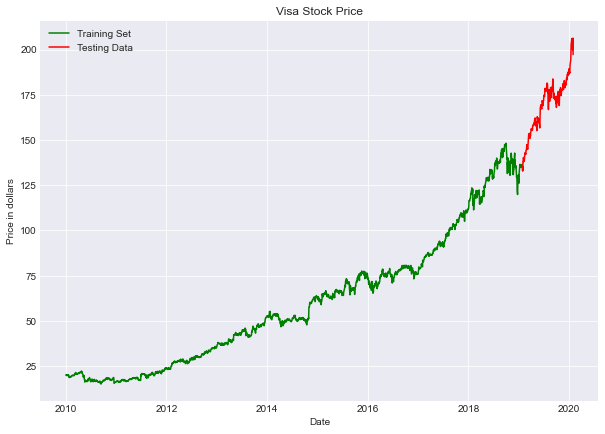

In [7]:
# Split data into train and test set
split = int(len(data)*0.90)
train_set, test_set = data[:split], data[split:]

# Plot Train and Test set
plt.figure(figsize=(10, 7))
plt.title('Visa Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.plot(train_set, 'green')
plt.plot(test_set, 'red')
plt.legend(['Training Set', 'Testing Data'])
plt.show()

### Partial Autocorrelation function plot

A partial autocorrelation function refers to the degree of correlation between data in a time series after controlling the effects of lagged observations. 

The number of significant lags for Partial Autocorrelation Function(PACF) plot suggests the order of the AR model. 

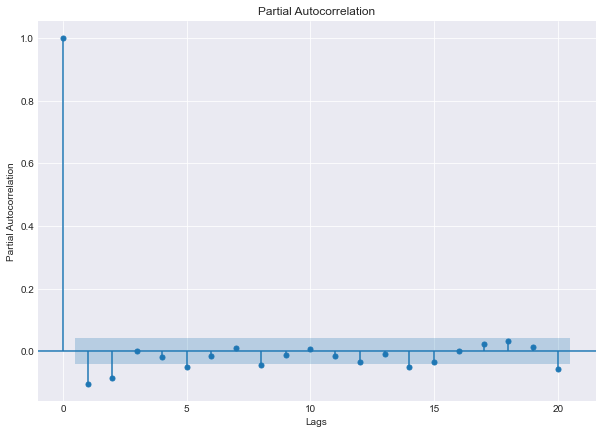

In [8]:
# Import plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Plot Partial Autocorrelation Function
plt.rcParams["figure.figsize"] = (10, 7)
plot_pacf(train_set.diff().dropna(), lags=20)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

A significant spike in Partial Autocorrelation values at lag 1 and lag 2 is observed in the above PACF plot, suggesting p=2 (AR term).

### Autocorrelation function plot
The number of significant lags for the Autocorrelation Function(ACF) plot suggests the order of the MA model.

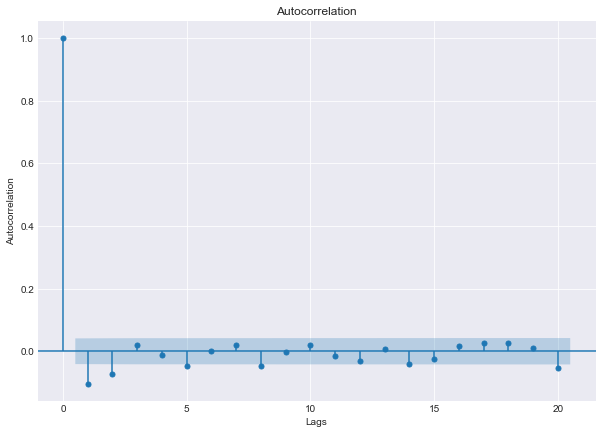

In [9]:
# Plot Autocorrelation Function
plt.rcParams["figure.figsize"] = (10, 7)
plot_acf(train_set.diff().dropna(), lags=20)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

A significant spike in autocorrelation values is observed at lag 1 and lag 2 in the above ACF plot. This suggests that q=2 (MA term). 

Both plots look similar, and this signifies that the correlation induced due to further lagged observations is minimal. However, this may not hold for other asset price time series. The reader is advised to experiment with different asset price time series to grasp this important concept fully.

### Information Criterion
When fitting the ARIMA model, it is possible to increase the model performance by adding more parameters. But doing so may result in overfitting. When overfitted, the model learns the details and noises in the training data to the extent that it negatively affects the model performance on test data. 

Information Criterion adds penalties for increasing model complexity. There are two popular Information Criterion, namely Akaike IC (AIC) and Bayesian IC (BIC). BIC imposes bigger penalties on models with more parameters as compared to AIC.

We'll tune p and q parameters separately using AIC and BIC and check if they agree with each other.

### Tuning p (AR term) parameter

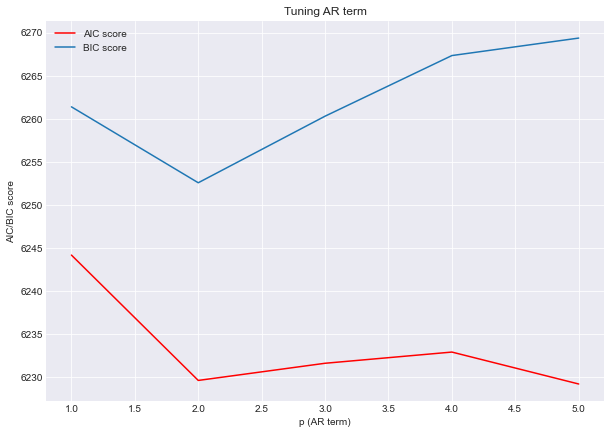

In [10]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import ARIMA
from statsmodels.tsa.arima_model import ARIMA

# Empty list to store aic/bic score
aic_p = []
bic_p = []

# p values
p = range(1, 6)  # [1,2,3,4,5]

# AIC/BIC score for different values of p
for i in p:
    # Define the AR model
    model = ARIMA(train_set, order=(i, 1, 0))  
    # Fit the model
    model_fit = model.fit(disp=-1)
    # Get AIC score
    aic_temp = model_fit.aic  
    # Get BIC score
    bic_temp = model_fit.bic
    # Append AIC score
    aic_p.append(aic_temp) 
    # Append BIC score
    bic_p.append(bic_temp) 
    
# Plot of AIC/BIC score for AR term
plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), aic_p, color='red')
plt.plot(range(1, 6), bic_p)
plt.title('Tuning AR term')
plt.xlabel('p (AR term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

BIC score suggests that p=2. This is in line with our observation from the PACF plot. Note that the AIC score is a little lower for p=5, but we'll be a bit conservative and continue with p=2.

### Tuning q (MA term) parameter

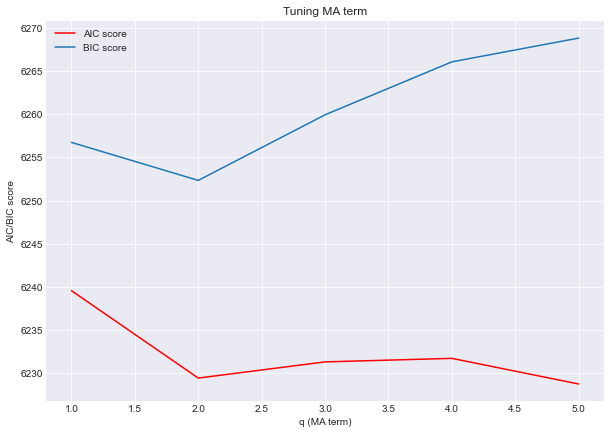

In [11]:
# Empty list to store AIC/BIC score
aic_q = []
bic_q = []

# q values
q = range(1, 6)

# AIC/BIC score for different values of q
for i in q:
    model = ARIMA(train_set, order=(0, 1, i))
    model_fit = model.fit(disp=-1)
    aic_temp = model_fit.aic
    bic_temp = model_fit.bic
    aic_q.append(aic_temp)
    bic_q.append(bic_temp)

# Plot of AIC/BIC score for MA term
plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), aic_q, color='red')
plt.plot(range(1, 6), bic_q)
plt.title('Tuning MA term')
plt.xlabel('q (MA term)')
plt.ylabel('AIC/BIC score')
plt.legend(['AIC score', 'BIC score'])
plt.show()

The BIC score suggests that q=2. This is again in line with our observation from the ACF plot.

### Build the ARIMA (p,d,q) model<a id='build'></a>

Thus our ARIMA model for p = 2 and q = 2 looks like : $$x'_t = b_0 + b_1 x'_{t-1} + b_2 x'_{t-2} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \epsilon_t$$

In [12]:
# Fit Athe RIMA model
model = ARIMA(train_set, order=(2, 1, 2))
model_fit_0 = model.fit()

## Forecast Using ARIMA model<a id='forecast'></a>

Forecasting using ARIMA is an iterative process where you have to update the train_set after each forecast and retrain the model every time with an updated train_set to make the next forecast. This is also known as Rolling Window forecast.


In [13]:
# Convert pandas series to list for rolling window forecast
past = train_set.tolist()

# Empty list for storing predictions
predictions = []

# Keeping only the first 50 data in the test dataset.
# You can run on the whole dataset, but it will take time to run.
test_set = test_set[:50]

# Perform rolling window forecast
for i in range(len(test_set)):
    # Define ARIMA model
    model = ARIMA(past, order=(2, 1, 2))
    # Fit the model
    model_fit = model.fit(
        disp=-1, start_params=model_fit_0.params)
    # Make forecast
    forecast_results = model_fit.forecast()
    pred = forecast_results[0][0]
    # Append prediction
    predictions.append(pred)
    # Add test value to train set
    past.append(test_set[i])

In [14]:
# Predicted and actual Values
for i in range(0, 10):
    print('predicted={pred}, actual={test}'.format(
        pred=predictions[i], test=test_set[i]))

predicted=133.28916157417532, actual=135.47885131835938
predicted=135.3913326131144, actual=132.9287567138672
predicted=133.18660086728445, actual=137.9895477294922
predicted=137.61037450778915, actual=139.31875610351562
predicted=138.84147086546938, actual=140.3328399658203
predicted=140.05516355473756, actual=139.30889892578125
predicted=139.17939310756006, actual=138.00926208496094
predicted=138.19488908190868, actual=138.2160186767578
predicted=138.26002211255422, actual=138.6295166015625
predicted=138.70288494524743, actual=139.80117797851562


## Evaluate Model Performance<a id='performance'></a>

Error Residuals are indicative of the performance of our predictive model. Mean Squared Error is another metric used to measure model performance.

### Residual

It is the difference between the observed value of a variable at a time 't' and its predicted value based on information available before time 't'. Error residual for a model that is good at making predictions should resemble white noise. 

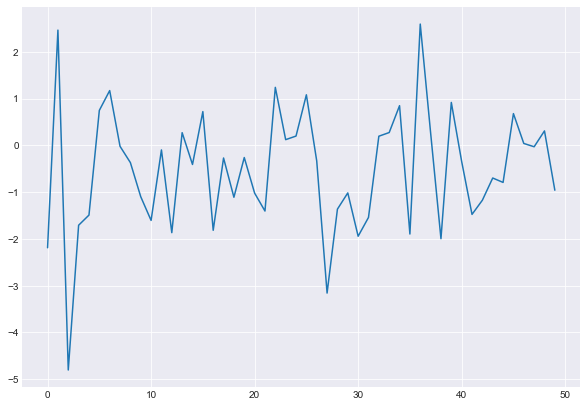

In [15]:
# Create empty list
residual = []

# Append residuals
for i in range(len(test_set)):
    residual.append(predictions[i]-test_set[i])

# Plot residuals
plt.figure(figsize=(10, 7))
plt.plot(residual)
plt.show()

<Figure size 720x504 with 0 Axes>

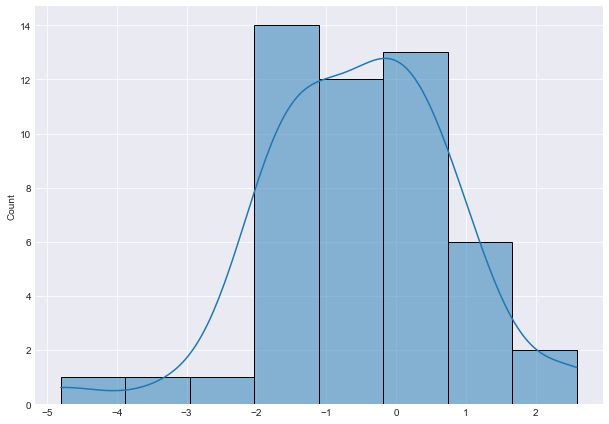

In [16]:
# Density plot
plt.figure(figsize=(10, 7))
sns.displot(residual, kde=True, height=6, aspect=10/7)
plt.show()

A model good at making predictions should have a density plot similar to a normal distribution. The density plot suggests that we can still work on improving the predictive power of the ARIMA model.

### Mean Squared Error (MSE)

We use the Mean Squared Error(MSE) to measure backtesting results. It is the average squared difference between the estimated values and the actual values. Smaller the MSE, the better the model performance. 

In [17]:
# Calculate MSE
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_set, predictions)
print('Test MSE: {mse}'.format(mse=error))

Test MSE: 2.0214442310745673


### Plot predictions and test data 

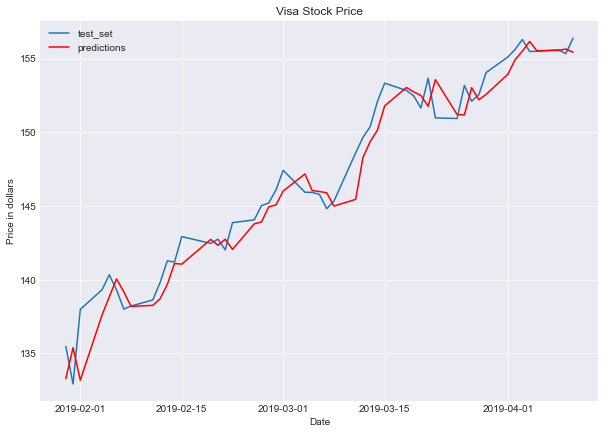

In [18]:
# Plot forecasted and actual values
plt.figure(figsize=(10, 7))
plt.plot(test_set)
plt.plot(test_set.index, predictions, color='red')
plt.title('Visa Stock Price')
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.legend(['test_set', 'predictions'])
plt.show()